# X Inactivation

I'd like to explore the state of genes on the X chromosome and see to what degree
the iPSCs reactivate their inactive Xs.

In [51]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy
import scipy.stats as stats 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'x_inactivation')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'x_inactivation')
cpy.makedir(private_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
sns.set_style('whitegrid')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'cnvs.tsv')
cnvs = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [5]:
# We'll keep female subjects with no CNVs on the X chromosome.
sf = subject_meta[subject_meta.sex == 'F']
meta = sf.merge(rna_meta, left_index=True, right_on='subject_id')
s = set(meta.subject_id) & set(cnvs.ix[cnvs.chr == 'chrX', 'subject_id'])
meta = meta[meta.subject_id.apply(lambda x: x not in s)]

meta = meta.ix[[x for x in snv_p.items if x in meta.index]]

snv_p = snv_p.ix[meta.index]

In [6]:
a = meta.shape[0]
b = len(set(meta.subject_id))
print('Using {} samples from {} female donors.'.format(a, b))

Using 144 samples from 116 female donors.


In [7]:
snv_p = snv_p.ix[meta.index]
locus_p = locus_p.ix[meta.index]

In [8]:
# Filter  and take log.
tpm_f = tpm[meta[meta.sex == 'F'].index]
tpm_f = tpm_f[(tpm_f != 0).sum(axis=1) > 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

## Inactivation for Single Sample

Let's take a look at one sample.

In [9]:
df = locus_p.ix[meta.index[0], :, :].dropna()
x_single = df[gene_info.ix[df.index, 'chrom'] == 'chrX']
notx_single = df[gene_info.ix[df.index, 'chrom'] != 'chrX']

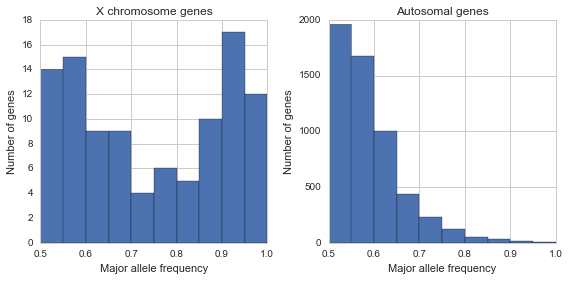

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
x_single.major_allele_freq.hist(ax=ax, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
ax = axs[1]
notx_single.major_allele_freq.hist(ax=ax, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
plt.tight_layout();
#plt.savefig(os.path.join(outdir, 'single_sample_majaf.pdf'))

This figure shows the distribution of gene major allele frequencies for
genes on the X chromosome and for genes on the autosomes. We can see that
autosomal genes often have a MajAF near 50% with few genes near 100%. However,
many X chromosome genes are near 100%. These genes are likely still inactivated.

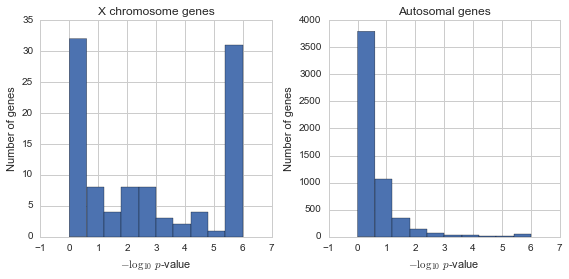

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
(-np.log10(x_single.p_val_ase + x_single.p_val_ase[x_single.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ax = axs[1]
(-np.log10(notx_single.p_val_ase + notx_single.p_val_ase[notx_single.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout();

We can see that the X chromosome is enriched for genes with strong ASE
likely due to incomplete X reactivation.

## Inactivation for All Samples

Let's take a look at all female samples.

In [12]:
t = locus_p.ix[:, :, 'major_allele_freq']
x_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index), :]
notx_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom != 'chrX'].index), :]

NANOG involved in the regulation of Xist (more NANOG expression -> less XIST expression though supposedly this doesn’t affect reactivation). OCT4 and SOX2 also supposed to affect XIST expresssion. cMYC, REX1, and KLF4 affect TSIX (this is all mouse stuff I think) (Minkovsky). 

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/seaborn/linearmodels.py:1282: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/seaborn/linearmodels.py:1348: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


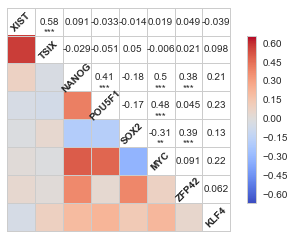

In [13]:
genes_to_plot = ['XIST', 'TSIX', 'NANOG', 'POU5F1', 'SOX2', 'MYC', 'ZFP42', 'KLF4']
t = pd.Series(gene_info.index, index=gene_info.gene_name)
    
exp = log_tpm_n.ix[t[genes_to_plot]].T
exp.columns = genes_to_plot
sns.corrplot(exp);

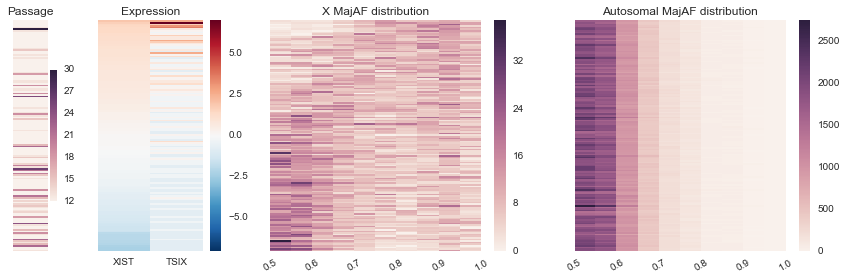

In [14]:
genes_to_plot = ['XIST', 'TSIX']
t = pd.Series(gene_info.index, index=gene_info.gene_name)
    
exp = log_tpm_n.ix[t[genes_to_plot]].T
exp.columns = genes_to_plot
# exp = log_tpm_n.ix[[gene_info[gene_info.gene_name == 'XIST'].index[0], 
#                     gene_info[gene_info.gene_name == 'TSIX'].index[0]]].T
# exp.columns = ['XIST', 'TSIX']
exp = exp.ix[x_all.items].sort_values(by='XIST', ascending=False)

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[0.5, 1.5, 3, 3])

ax = plt.subplot(gs[0])
sns.heatmap(np.array([meta.ix[exp.index, 'passage'].values]).T, 
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Passage')

ax = plt.subplot(gs[1])
sns.heatmap(exp, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Expression')
#for t in ax.get_xticklabels():
#    t.set_rotation(30)

ax = plt.subplot(gs[2])
r = x_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                       bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
ax.set_title('X MajAF distribution')

ax = plt.subplot(gs[3])
r = notx_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                          bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
ax.set_title('Autosomal MajAF distribution')

gs.tight_layout(fig)
fig.savefig(os.path.join(outdir, 'x_reactivation_heatmap.png'), dpi=600)

These heatmaps are all aligned by row (so the first row across all heatmaps
is the same sample, the second row across all heatmaps is the same sample, etc.).
The heatmaps are ordered by each sample's XIST expression (shown in the second heatmap).
The X MajAF distribution heatmap is the same as the histogram above for one sample
but now we are stacking up the histograms for all samples. We can see that many
samples have genes that are inactive although the amount of inactivation varies
between samples and is highly correlated with XIST.

The X chromosome is clearly enriched for having ASE which is probably due
to incomplete X reactivation.

In [15]:
t = x_all.ix[:, :, 'p_val_ase']
freq = (t < 0.005).sum() / (t.isnull() == False).sum()
print('{:.2f}% of genes per sample have significant ASE on chrX.'.format(freq.mean() * 100))
t = notx_all.ix[:, :, 'p_val_ase']
freq = (t < 0.005).sum() / (t.isnull() == False).sum()
print('{:.2f}% of genes per sample have significant ASE on autosomes.'.format(freq.mean() * 100))

44.58% of genes per sample have significant ASE on chrX.
2.87% of genes per sample have significant ASE on autosomes.


In [16]:
xist_gene_id = gene_info[gene_info.gene_name == 'XIST'].index[0]
tsix_gene_id = gene_info[gene_info.gene_name == 'TSIX'].index[0]

In [17]:
r = stats.spearmanr(meta.passage, log_tpm_n.ix[xist_gene_id, meta.index])
print('Passage and XIST expression are correlated (r={:.2f}) with p={:.3f}.'.format(
    r.correlation, r.pvalue))

Passage and XIST expression are correlated (r=-0.22) with p=0.007.


In [18]:
r = stats.spearmanr(meta.passage, log_tpm_n.ix[tsix_gene_id, meta.index])
print('Passage and TSIX expression are correlated (r={:.2f}) with p={:.3f}.'.format(
    r.correlation, r.pvalue))

Passage and TSIX expression are correlated (r=-0.20) with p=0.018.


In [19]:
percent_ase = ((x_all.ix[:, :, 'p_val_ase'] < 0.005).sum() / 
               (x_all.ix[:, :, 'p_val_ase'].isnull() == False).sum())

In [20]:
r = stats.spearmanr(percent_ase, meta.ix[percent_ase.index, 'passage'])
print('Percent ASE and passage are not correlated (r={:.2f}, p={:.3f}).'.format(
    r.correlation, r.pvalue))

Percent ASE and passage are not correlated (r=-0.06, p=0.449).


In [21]:
r = stats.spearmanr(percent_ase, log_tpm_n.ix[xist_gene_id, percent_ase.index])
print('Percent ASE and XIST expression are correlated (r={:.2f}) with p={:.3e}.'.format(
    r.correlation, r.pvalue))

Percent ASE and XIST expression are correlated (r=0.75) with p=2.299e-27.


In [22]:
r = stats.spearmanr(percent_ase, log_tpm_n.ix[tsix_gene_id, percent_ase.index])
print('Percent ASE and TSIX expression are correlated (r={:.2f}) with p={:.3e}.'.format(
    r.correlation, r.pvalue))

Percent ASE and TSIX expression are correlated (r=0.53) with p=5.179e-12.


### X chromosome gene expression

Are reactivated genes expressed more highly?

In [23]:
fn = os.path.join(outdir, 'x_ase_exp.tsv')
if not os.path.exists(fn):
    t = locus_p.ix[:, :, 'p_val_ase']
    t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
    t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
    t = t.ix[set(log_tpm_n.index) & set(t.index)]

    rows = []
    for i in t.index:
        se = t.ix[i]
        se = se[se.isnull() == False]
        a = log_tpm_n.ix[i, se[se <= 0.005].index]
        b = log_tpm_n.ix[i, se[se > 0.005].index]

        rows.append([se.shape[0], a.shape[0], b.shape[0], a.mean(), b.mean()])

    x_exp = pd.DataFrame(rows, columns=['num_samples', 'num_sig', 'num_not_sig', 
                                        'mean_sig_exp', 'mean_not_sig_exp'],
                         index=t.index)
    x_exp = x_exp[(x_exp.num_sig >= 5) & (x_exp.num_not_sig >= 5)]
    x_exp.to_csv(fn, sep='\t')
else:
    x_exp = pd.read_table(fn, index_col=0)

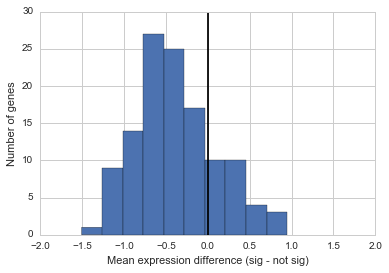

In [24]:
(x_exp.mean_sig_exp - x_exp.mean_not_sig_exp).hist()
plt.ylabel('Number of genes')
plt.xlabel('Mean expression difference (sig - not sig)')
xmin, xmax = plt.xlim()
plt.xlim(-max(abs(xmin), abs(xmax)), max(abs(xmin), abs(xmax)))
ymin, ymax = plt.ylim()
plt.vlines(0, ymin, ymax);

The histogram above shows that genes have higher average expression
in samples where the gene does not have significant ASE.

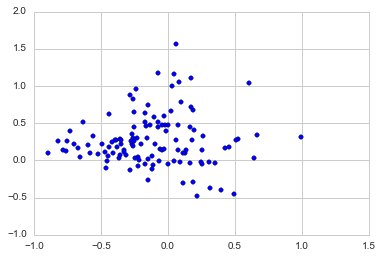

In [77]:
plt.scatter(x_exp.mean_sig_exp, x_exp.mean_not_sig_exp)
# xmin,xmax = plt.xlim()
# ymin,ymax = plt.ylim()
# plt.plot([-1, 2], [-1, 2])
# plt.xlim(-1, 1.75)
# plt.ylim(-1, 1.75)

In [65]:
len(set([x[0] for x in no_sig_ase.index]))

155

In [64]:
len(set([x[0] for x in sig_ase.index]))

156

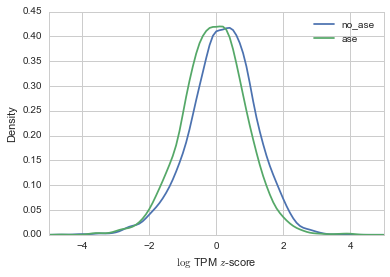

In [60]:
t = locus_p.ix[:, :, 'p_val_ase']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
t = t.ix[set(log_tpm_n.index) & set(t.index)]
exp = log_tpm_n.ix[t.index, t.columns]

no_sig_ase = exp[t > 0.005].stack()
sig_ase = exp[t < 0.005].stack()

pdfs = pd.DataFrame(index=np.arange(-5, 5 + 0.1, 0.1))
density = scipy.stats.gaussian_kde(no_sig_ase)
pdfs['no_ase'] = density(pdfs.index)
density = scipy.stats.gaussian_kde(sig_ase)
pdfs['ase'] = density(pdfs.index)
pdfs.to_csv(os.path.join(outdir, 'expression_densities.tsv'), sep='\t')
pdfs.plot()
plt.ylabel('Density')
plt.xlabel('$\log$ TPM $z$-score');

### Reactivation percent

Only some genes show residual inactivation. Are these the same genes across samples?

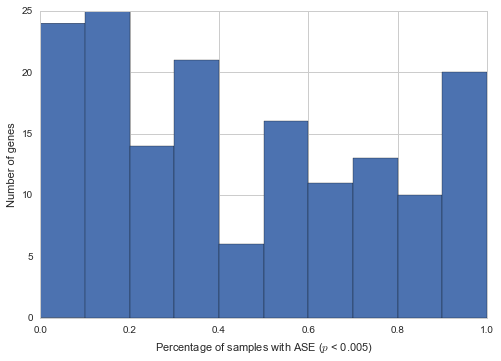

In [32]:
t = locus_p.ix[:, :, 'p_val_ase']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
freq = (t[t.isnull() == False] < 0.005).sum(axis=1) / (t.isnull() == False).sum(axis=1)

freq.hist()
plt.ylabel('Number of genes')
plt.xlabel('Percentage of samples with ASE ($p$ < 0.005)');

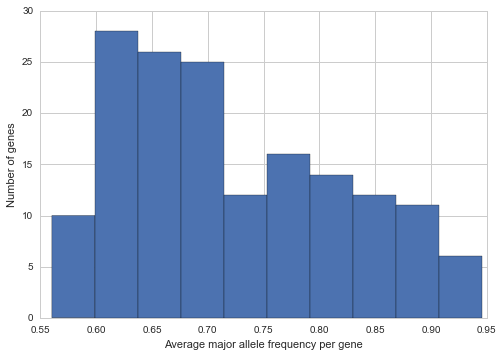

In [33]:
tt = locus_p.ix[:, t.index, 'major_allele_freq']

tt.mean(axis=1).hist()
plt.ylabel('Number of genes')
plt.xlabel('Average major allele frequency per gene');

The above histogram shows what percentage of samples were significant
for ASE. Note that a gene in a sample is
included here only if it was tested by MBASED for ASE. I restricted to
genes that were tested by MBASED in at least 20% of the samples.

## Reactivation across the X chromosome

I'd like to look at how genes are reactivated across the X chromosome.
For instance, is reactivation correlated with replication timing or 
L1 density? I can consider things like

* replication timing 
* distance from centromere or telomere 
* XIST binding motif density (does it have a binding motif?)
* distance from X inactivation center
* L1 density

In [34]:
t = gene_info.ix[x_all.major_axis]
r = ((t.end - t.start) / 2).astype(int)
start = (t.start + r - (((t.end - t.start) / 2 % 1) == 0)).astype(int).astype(str)
end = (t.end - r).astype(int).astype(str)
s = '\n'.join(t.chrom + '\t' + start + '\t' + end + '\t' + 
              pd.Series(t.index, index=t.index)) + '\n'
xgenes_center_bt = pbt.BedTool(s, from_string=True)
xgenes_center_bt = xgenes_center_bt.sort()

### Replication timing

In [35]:
# Replication timing data.
rt = pd.read_table('/publicdata/replication_domain_db_20151103/RD_sm300_2936763_hFibiPS4p72.hg19.txt',
                   low_memory=False, skiprows=15, index_col=0)
rt = rt[rt.Chromosome == 'chrX']
s = '\n'.join(rt.Chromosome + '\t' + rt.Start_Position.astype(str) + 
              '\t' + rt.End_Position.astype(str) + '\t' + rt.Data_Value.astype(str))
rt_bt = pbt.BedTool(s, from_string=True)
rt_bt = rt_bt.sort()

In [36]:
res = xgenes_center_bt.closest(rt_bt, d=True)
df = res.to_dataframe()
rt_by_gene = pd.Series(df.thickEnd.values, index=df.name)

### L1 elements

I downloaded the repeat masker database from the table browser (group: Repeats, 
track: RepeatMasker, output format: all fields from selected table) to the file
`rmsk_db.txt.gz`. I also downloaded the database as a bed file from the table browser
to the file `rmsk.bed`. I put both of these in the output directory.

In [37]:
fn = os.path.join(outdir, 'line_one_elements.tsv')
if not os.path.exists(fn):
    rmsk = os.path.join(outdir, 'rmsk_db.txt.gz')
    repeat_db = pd.read_table(rmsk, low_memory=False)
    line_one_elements = repeat_db[repeat_db.repFamily == 'L1']
    line_one_elements = line_one_elements[line_one_elements.genoName == 'chrX']
    line_one_elements.to_csv(fn, sep='\t')
else:
    line_one_elements = pd.read_table(fn, index_col=0)
    
fn = os.path.join(outdir, 'line_one_elements.bed')
if not os.path.exists(fn):
    repeats = pd.read_table(os.path.join(outdir, 'rmsk.bed'), header=None, low_memory=False)
    repeats = repeats[repeats[0] == 'chrX']
    repeat_db = pd.read_table(rmsk, low_memory=False)
    se = pd.Series(dict(zip(repeat_db.repName, repeat_db.repFamily)))
    r = repeats[repeats[3].apply(lambda x: se[x] == 'L1')]
    s = '\n'.join(['\t'.join(x) for x in r.astype(str).values]) + '\n'
    line_one_bt = pbt.BedTool(s, from_string=True)
    line_one_bt = line_one_bt.sort()
    line_one_bt.saveas(fn)
else:
    line_one_bt = pbt.BedTool(fn)
    
res = xgenes_center_bt.window(line_one_bt, w=100000)
df = res.to_dataframe()
line_one_by_gene = df.name.value_counts()

In [38]:
line_one_bedgraph = os.path.join(outdir, 'line_one.bedGraph')
if not os.path.exists(line_one_bedgraph):
    res = line_one_bt.genome_coverage(g=pbt.genome_registry.hg19, bg=True)
    res.saveas(line_one_bedgraph)
    
line_one_bw = os.path.join(outdir, 'line_one.bw')
if not os.path.exists(line_one_bw):
    !bedGraphToBigWig {line_one_bedgraph} /software/bedtools-2.25.0/genomes/human.hg19.genome {line_one_bw}

In [39]:
line_one_bam = os.path.join(outdir, 'line_one_uniq_sorted.bam')
if not os.path.exists(line_one_bam):
    df = line_one_bt.to_dataframe()
    df.name = df.name + '_' + pd.Series(range(df.shape[0])).astype(str)
    fn = os.path.join(outdir, 'line_one_uniq.bed')
    df.to_csv(fn, header=None, index=None, sep='\t')
    out = os.path.join(outdir, 'line_one_uniq.bam')
    !bedToBam -i {fn} -g /frazer01/software/bedtools-2.25.0/genomes/human.hg19.genome > {out}
    !sambamba sort -o {line_one_bam} {out}
    !sambamba index {line_one_bam}
    !rm {out}

In [40]:
fn = os.path.join(outdir, 'alu_elements.tsv')
if not os.path.exists(fn):
    rmsk = os.path.join(outdir, 'rmsk_db.txt.gz')
    repeat_db = pd.read_table(rmsk, low_memory=False)
    alu_elements = repeat_db[repeat_db.repFamily == 'Alu']
    alu_elements.to_csv(fn, sep='\t')
else:
    alu_elements = pd.read_table(fn, index_col=0)
    
fn = os.path.join(outdir, 'alu_elements.bed')
if not os.path.exists(fn):
    repeats = pd.read_table(os.path.join(outdir, 'rmsk.bed'), header=None, low_memory=False)
    repeat_db = pd.read_table(rmsk, low_memory=False)
    se = pd.Series(dict(zip(repeat_db.repName, repeat_db.repFamily)))
    r = repeats[repeats[3].apply(lambda x: se[x] == 'Alu')]
    s = '\n'.join(['\t'.join(x) for x in r.astype(str).values]) + '\n'
    alu_bt = pbt.BedTool(s, from_string=True)
    alu_bt.saveas(fn)
else:
    alu_bt = pbt.BedTool(fn)
    
res = xgenes_center_bt.window(alu_bt, w=100000)
df = res.to_dataframe()
alu_by_gene = df.name.value_counts()

In [41]:
fn = os.path.join(outdir, 'line_two_elements.tsv')
if not os.path.exists(fn):
    rmsk = os.path.join(outdir, 'rmsk_db.txt.gz')
    repeat_db = pd.read_table(rmsk, low_memory=False)
    line_two_elements = repeat_db[repeat_db.repFamily == 'L2']
    line_two_elements.to_csv(fn, sep='\t')
else:
    line_two_elements = pd.read_table(fn, index_col=0)
    
fn = os.path.join(outdir, 'line_two_elements.bed')
if not os.path.exists(fn):
    repeats = pd.read_table(os.path.join(outdir, 'rmsk.bed'), header=None, low_memory=False)
    repeat_db = pd.read_table(rmsk, low_memory=False)
    se = pd.Series(dict(zip(repeat_db.repName, repeat_db.repFamily)))
    r = repeats[repeats[3].apply(lambda x: se[x] == 'L2')]
    s = '\n'.join(['\t'.join(x) for x in r.astype(str).values]) + '\n'
    line_two_bt = pbt.BedTool(s, from_string=True)
    line_two_bt.saveas(fn)
else:
    line_two_bt = pbt.BedTool(fn)
    
res = xgenes_center_bt.window(line_two_bt, w=100000)
df = res.to_dataframe()
line_two_by_gene = df.name.value_counts()

### Combine features

In [42]:
df = xgenes_center_bt.to_dataframe()
pos = pd.Series(df.start.values, index=df.name)
features = pd.DataFrame({'rep_timing':rt_by_gene, 'line1':line_one_by_gene, 'pos':pos,
                         'alu':alu_by_gene, 'line2':line_two_by_gene})

I downloaded the banding track from the table browser (group: Mapping and Sequencing,
track: Chromosome Band, table: cytoBand) to `cytoBand_db.txt` in the output directory.

In [43]:
cyto = pd.read_table(os.path.join(outdir, 'cytoBand_db.txt'))
cyto.columns = [x.replace('#', '') for x in cyto.columns]

In [44]:
cyto.ix[(cyto.chrom == 'chrX') & (cyto.gieStain == 'acen')]

,chrom,chromStart,chromEnd,name,gieStain
469,chrX,58100000,60600000,p11.1,acen
470,chrX,60600000,63000000,q11.1,acen


In [45]:
%%R

suppressPackageStartupMessages(library(lme4))

In [46]:
lmm_features = pd.DataFrame(x_all.ix[:, :, 'major_allele_freq'].stack(), 
                            columns=['major_allele_freq'])
lmm_features.index.names = ['gene_id', 'sample_id']
lmm_features = lmm_features.reset_index()
t = pd.DataFrame(x_all.ix[:, :, 'p_val_ase'].stack(), 
                 columns=['p_val_ase'])
t.index.names = ['gene_id', 'sample_id']
t = t.reset_index()
lmm_features['p_val_ase'] = t['p_val_ase']
lmm_features = lmm_features.merge(features[['line1', 'alu', 'line2', 'pos', 'rep_timing']], 
                                  left_on='gene_id', right_index='True')

t = log_tpm_n.stack()
t = t.reset_index()
t.columns = ['gene_id', 'sample_id', 'exp']
t.index = t.gene_id + ':' + t.sample_id
lmm_features['exp'] = t.ix[lmm_features.gene_id + ':' + lmm_features.sample_id, 'exp'].values
lmm_features = lmm_features.dropna()

# random.seed('5454')
# rand = [random.random() for x in range(lmm_features.shape[0])]
# lmm_features['random'] = rand
random.seed('5454')
rand = [random.random() for x in set(lmm_features.gene_id)]
se = pd.Series(rand, index=set(lmm_features.gene_id))
lmm_features['random'] = se[lmm_features.gene_id].values

lmm_features_p = lmm_features[lmm_features.pos < 58100000]
lmm_features_q = lmm_features[lmm_features.pos > 63000000]

lmm_features.pos = lmm_features.pos - lmm_features.pos.min()
lmm_features.pos = lmm_features.pos  / lmm_features.pos.max()

lmm_features.line1 = lmm_features.line1 - lmm_features.line1.min()
lmm_features.line1 = lmm_features.line1  / lmm_features.line1.max()

lmm_features.alu = lmm_features.alu - lmm_features.alu.min()
lmm_features.alu = lmm_features.alu  / lmm_features.alu.max()

lmm_features.line2 = lmm_features.line2 - lmm_features.line2.min()
lmm_features.line2 = lmm_features.line2  / lmm_features.line2.max()

lmm_features_p = lmm_features.ix[lmm_features_p.index]
lmm_features_q = lmm_features.ix[lmm_features_q.index]

In [47]:
%%R -i lmm_features

model = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), data=lmm_features)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
   Data: lmm_features

REML criterion at convergence: -14002.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5899 -0.8089 -0.1123  0.8129  2.5679 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.001855 0.04307 
 Residual              0.018213 0.13496 
Number of obs: 12308, groups:  sample_id, 144

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.683307   0.004877  140.11
exp         -0.022137   0.001346  -16.45
line1        0.094432   0.007343   12.86
pos          0.062206   0.003898   15.96
rep_timing  -0.012542   0.001599   -7.84

Correlation of Fixed Effects:
           (Intr) exp    line1  pos   
exp        -0.022                     
line1      -0.377  0.003              
pos        -0.345 -0.021 -0.167       
rep_timing -0.306  0.006 -0.086  0.157


In [48]:
%%R -i lmm_features_p

model = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), data=lmm_features_p)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
   Data: lmm_features_p

REML criterion at convergence: -7327.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5157 -0.7581 -0.1261  0.7281  3.0087 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.001846 0.04296 
 Residual              0.014837 0.12181 
Number of obs: 5549, groups:  sample_id, 144

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.656776   0.005418  121.21
exp         -0.023410   0.001840  -12.72
line1       -0.102725   0.012214   -8.41
pos          0.612135   0.017927   34.15
rep_timing  -0.009300   0.002236   -4.16

Correlation of Fixed Effects:
           (Intr) exp    line1  pos   
exp        -0.016                     
line1      -0.278 -0.001              
pos        -0.286 -0.042 -0.480       
rep_timing -0.362  0.021 -0.264  0.214


In [49]:
%%R -i lmm_features_q

model = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), data=lmm_features_q)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
   Data: lmm_features_q

REML criterion at convergence: -7487.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.56268 -0.81750 -0.05648  0.83158  2.51166 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.002052 0.04529 
 Residual              0.018494 0.13599 
Number of obs: 6757, groups:  sample_id, 144

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.715053   0.010201   70.09
exp         -0.022906   0.001810  -12.66
line1        0.106992   0.009705   11.02
pos         -0.000799   0.011018   -0.07
rep_timing  -0.002976   0.002201   -1.35

Correlation of Fixed Effects:
           (Intr) exp    line1  pos   
exp        -0.017                     
line1      -0.464  0.016              
pos        -0.845 -0.007  0.191       
rep_timing -0.073 -0.005 -0.038 -0.096


#### Whole chromosome

#####  LINE 1 elements

In [50]:
%%R

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features
Models:
model.null: major_allele_freq ~ exp + pos + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df    AIC    BIC logLik deviance Chisq Chi Df Pr(>Chisq)    
model.null  6 -13876 -13831 6943.8   -13888                            
model.full  7 -14038 -13986 7026.0   -14052 164.3      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Position

In [51]:
%%R

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features
Models:
model.null: major_allele_freq ~ exp + line1 + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -13788 -13743 6899.9   -13800                             
model.full  7 -14038 -13986 7026.0   -14052 252.19      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Replicating timing

In [52]:
%%R

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + pos + (1|sample_id), 
                  data=lmm_features, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features
Models:
model.null: major_allele_freq ~ exp + line1 + pos + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df    AIC    BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -13978 -13934 6995.3   -13990                             
model.full  7 -14038 -13986 7026.0   -14052 61.395      1  4.669e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### p arm

###### LINE 1 elements

In [53]:
%%R -i lmm_features_p

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_p
Models:
model.null: major_allele_freq ~ exp + pos + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -7288.8 -7249.1 3650.4  -7300.8                             
model.full  7 -7357.1 -7310.7 3685.5  -7371.1 70.286      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Position

In [54]:
%%R -i lmm_features_p

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_p
Models:
model.null: major_allele_freq ~ exp + line1 + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -6303.5 -6263.7 3157.7  -6315.5                             
model.full  7 -7357.1 -7310.7 3685.5  -7371.1 1055.6      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Replication timing

In [55]:
%%R -i lmm_features_p

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + pos + (1|sample_id), 
                  data=lmm_features_p, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_p
Models:
model.null: major_allele_freq ~ exp + line1 + pos + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -7341.8 -7302.1 3676.9  -7353.8                             
model.full  7 -7357.1 -7310.7 3685.5  -7371.1 17.287      1  3.214e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### q arm

##### LINE 1 elements

In [56]:
%%R -i lmm_features_q

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_q
Models:
model.null: major_allele_freq ~ exp + pos + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
model.null  6 -7399.7 -7358.7 3705.8  -7411.7                             
model.full  7 -7518.2 -7470.4 3766.1  -7532.2 120.51      1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


##### Position

In [57]:
%%R -i lmm_features_q

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_q
Models:
model.null: major_allele_freq ~ exp + line1 + rep_timing + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)
model.null  6 -7520.2 -7479.3 3766.1  -7532.2                         
model.full  7 -7518.2 -7470.4 3766.1  -7532.2 0.0051      1     0.9429


##### Replication timing

In [58]:
%%R -i lmm_features_q

model.full = lmer(major_allele_freq ~ exp + line1 + pos + rep_timing + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
model.null = lmer(major_allele_freq ~ exp + line1 + pos + (1|sample_id), 
                  data=lmm_features_q, REML=FALSE)
anova(model.null, model.full)

Data: lmm_features_q
Models:
model.null: major_allele_freq ~ exp + line1 + pos + (1 | sample_id)
model.full: major_allele_freq ~ exp + line1 + pos + rep_timing + (1 | sample_id)
           Df     AIC     BIC logLik deviance  Chisq Chi Df Pr(>Chisq)
model.null  6 -7518.3 -7477.4 3765.2  -7530.3                         
model.full  7 -7518.2 -7470.4 3766.1  -7532.2 1.8285      1     0.1763


In [59]:
rt_data = rt[['Chromosome', 'Start_Position', 'End_Position', 'Data_Value']]
rt_data.columns = ['chromosome', 'start', 'end', 'Replication Timing']

In [60]:
%%R

suppressPackageStartupMessages(library(Gviz))

In [61]:
%%R -i rt_data

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX")
rtTrack <- DataTrack(range=rt_data, genome="hg19", type=c("polygon"),
                     chromosome="chrX", name="Replication Timing")

In [62]:
%%R -i line_one_bw

#bamFile <- system.file(line_one_bam, package = "Gviz")
lineTrack <- DataTrack(range=line_one_bw, genome="hg19", type="l", window=-1,
                       chromosome="chrX", name="L1 Elements", )

In [64]:
lmm_features = lmm_features.merge(gene_info[['chrom', 'start', 'end']], 
                                  left_on='gene_id', right_index=True)
lmm_features.columns = [c.replace('chrom', 'chromosome') for c in lmm_features.columns]

In [111]:
t = x_all.ix[:, :, 'major_allele_freq']
r = gene_info.ix[t.index, ['start', 'end']]

In [66]:
%%R -i t,r

mafTrack <- DataTrack(range=r, data=t, genome="hg19", type=c("smooth", "p"), alpha=0.75, lwd=8,
                      span=0.05,
                      chromosome="chrX", name="Major Allele Frequency")

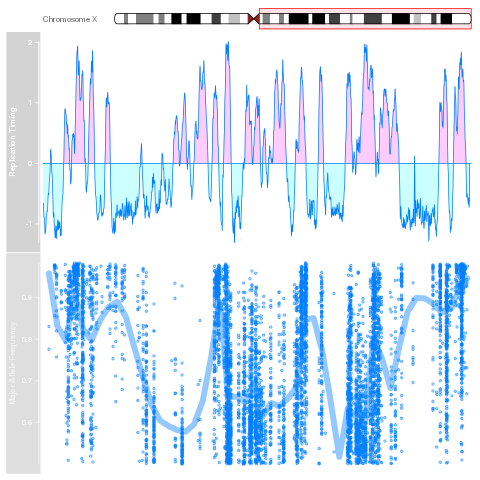

In [67]:
%%R

plotTracks(c(ideoTrack, rtTrack, mafTrack), from=63000000, to=155270560)

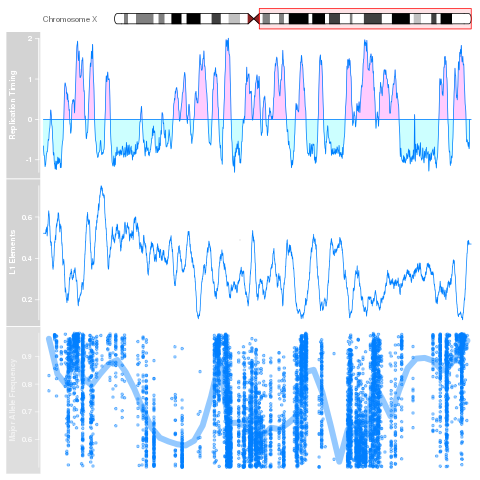

In [70]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=63000000, to=155270560)

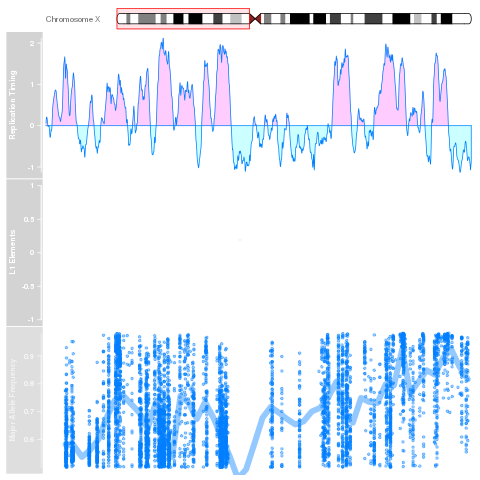

In [76]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=0, to=58100000)

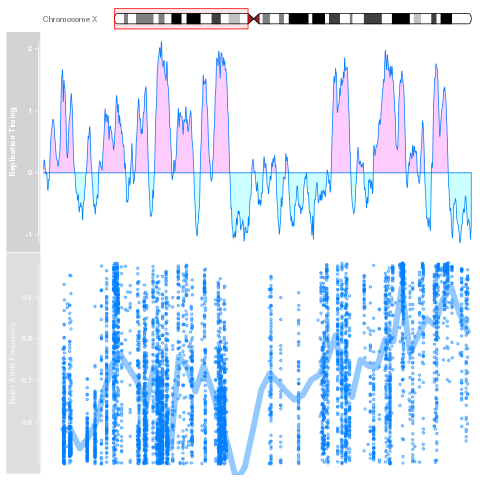

In [226]:
%%R

plotTracks(c(ideoTrack, rtTrack, lineTrack, mafTrack), from=0, to=58100000)

In [ ]:
%%R -i rt_bedgraph,sig_bedgraph,mean_freq_z_bedgraph,line_one_bam

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX")
# sig <- system.file(sig_bedgraph, package = "Gviz")
sigTrack <- DataTrack(range=sig_bedgraph, genome="hg19", type=c("smooth", "p"),
                      chromosome="chrX", name="Percent Significant ASE")
# mfz <- system.file(sig_bedgraph, package = "Gviz")
mfzTrack <- DataTrack(range=mean_freq_z_bedgraph, genome="hg19", type=c("smooth", "p"),
                      chromosome="chrX", name="Mean Frequency z Score")
#rt <- system.file(rt_bedgraph, package = "Gviz")
rtTrack <- DataTrack(range=rt_bedgraph, genome="hg19", type="l",
                     chromosome="chrX", name="Replication Timing")
lineTrack <- DataTrack(range=line_one_bam, genome="hg19", type="l", window=-1,
                       chromosome="chrX", name="L1 Elements")

## Reactivation QTLs

In [34]:
g = set(gene_info[gene_info.chrom == 'chrX'].index) & set(ase_pval.index)
s = meta[(meta.sex == 'F') & (meta.in_eqtl)].index
fx_maj_af = maj_af.ix[g, s]
fx_maj_af_f = fx_maj_af[(fx_maj_af.isnull() == False).sum(axis=1) >= 40]

In [35]:
fx_maj_af_f.shape

(108, 116)

In [36]:
g = set(gene_info[gene_info.chrom == 'chrX'].index) & set(ase_pval.index)
s = meta[(meta.sex == 'F') & (meta.in_eqtl)].index
fx_maj_af = maj_af.ix[g, s]
fx_maj_af_f = fx_maj_af[(fx_maj_af.isnull() == False).sum(axis=1) >= 40]

In [37]:
cpy.makedir(os.path.join(outdir, 'inact_qtl'))
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'gene_to_regions.p')
gene_to_regions = cPickle.load(open(fn, 'rb'))

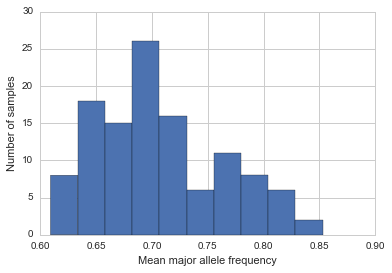

In [38]:
fx_maj_af_f.mean().hist()
plt.ylabel('Number of samples')
plt.xlabel('Mean major allele frequency');

I'm going to substract the mean from each sample (column) to account for 
differences in overall reactivation.

In [39]:
fx_maj_af_f = fx_maj_af_f - fx_maj_af_f.mean()

In [44]:
fx_maj_af_f.shape

(108, 116)

In [40]:
def run_emmax_sge(gene_id, mem=4):
    """Run EMMAX for X inactivation eQTL."""
    se = fx_maj_af_f.ix[gene_id].dropna()
    se = cpb.general.transform_standard_normal(se)
    wgs = cpy.get_best_wgs_sample(meta.ix[se.index, 'subject_id'])
    se.index = wgs.wgs_id
    se = se[sorted(se.index)]
    
    toutdir = os.path.join(outdir, 'inact_qtl', gene_id)
    cpy.makedir(toutdir)
    
    samples = os.path.join(toutdir, 'emmax_samples.tsv')
    with open(samples, 'w') as f:
        f.write('\n'.join(se.index) + '\n')
    
    exp = os.path.join(toutdir, 'maj_af_std_norm.tsv')
    pd.DataFrame(se, columns=[gene_id]).T.to_csv(exp, sep='\t')
    
    vcf = '/projects/CARDIPS/pipeline/WGS/mergedVCF/CARDIPS_201512.femaleX.PASS.vcf.gz'
    regions = ','.join([x[3:] for x in gene_to_regions[gene_id]])
    kin = os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin')

    res = datetime.datetime.now()
    date = re.sub(r'\D', '_', str(res))
    fn = os.path.join(toutdir, '{}_{}.sh'.format(gene_id, date))
    with open(fn, 'w') as f:
        f.write('#!/bin/bash\n\n')
        f.write('#$ -N emmax_{}_{}_x\n'.format(gene_id, date))
        num_threads = 4
        f.write('#$ -l short\n')
        f.write('#$ -l h_vmem={}G\n'.format(mem / num_threads))
        f.write('#$ -pe smp {}\n'.format(num_threads))
        f.write('#$ -S /bin/bash\n')
        f.write('#$ -o {}/emmax_{}_{}_x.out\n'.format(toutdir, gene_id, date))
        f.write('#$ -e {}/emmax_{}_{}_x.err\n\n'.format(toutdir, gene_id, date))
        f.write('module load cardips/1\n')
        f.write('source activate cie\n\n')
        
        cpy.makedir(toutdir)
        c = 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                vcf,
                regions,
                exp,
                samples,
                kin,
                toutdir,
            ])
        f.write(c + '\n\n')
    subprocess.check_call('qsub {}'.format(fn), shell=True)

In [42]:
if not os.path.exists(os.path.join(outdir, 'inact_qtl')):
    for g in fx_maj_af_f.index:
        run_emmax_sge(g)

In [45]:
dys = glob.glob(os.path.join(outdir, 'inact_qtl', '*'))
gene_ids = []
pvalues = []
for dy in dys:
    gene_id = os.path.split(dy)[1]
    res_fn = os.path.join(os.path.join(dy, '{}.tsv'.format(gene_id)))
    res = ciepy.read_emmax_output(res_fn)
    min_fn = os.path.join(os.path.join(dy, 'minimum_pvalues.tsv'))
    min_pvals = pd.read_table(min_fn, header=None, squeeze=True)
    pvalues.append((1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1))
    gene_ids.append(gene_id)
pvalues = pd.Series(pvalues, index=gene_ids)

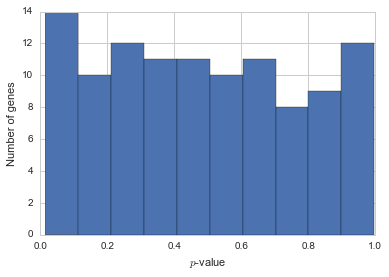

In [46]:
pvalues.hist()
plt.xlabel('$p$-value')
plt.ylabel('Number of genes');

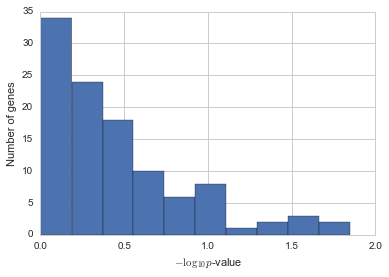

In [47]:
(-np.log10(pvalues)).hist()
plt.xlabel('$-\log_{10} p$-value')
plt.ylabel('Number of genes');

In [48]:
r = sms.sandbox.stats.multicomp.multipletests(pvalues, method='fdr_bh')
pvalues_bh = pd.Series(r[1], index=pvalues.index)
sum(pvalues_bh < 0.05)

0

In [49]:
pvalues = pvalues.sort_values()

The following genes are nominally significant but don't pass the FDR correction.

In [50]:
gene_info.ix[pvalues[pvalues < 0.05].index]

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
ENSG00000238178.2,RP11-431J24.2,antisense,chrX,16171063,16188992,-,NOVEL,HAVANA,2
ENSG00000102010.10,BMX,protein_coding,chrX,15482368,15574652,+,KNOWN,HAVANA,2
ENSG00000131725.9,WDR44,protein_coding,chrX,117480035,117583924,+,KNOWN,HAVANA,2
ENSG00000204466.5,DGKK,processed_transcript,chrX,50108407,50213737,-,KNOWN,HAVANA,2
ENSG00000087842.6,PIR,protein_coding,chrX,15402920,15511687,-,KNOWN,HAVANA,2
ENSG00000068400.9,GRIPAP1,protein_coding,chrX,48830133,48858675,-,KNOWN,HAVANA,2
ENSG00000130741.6,EIF2S3,protein_coding,chrX,24072832,24096088,+,KNOWN,HAVANA,2
